In [39]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [40]:
import numpy as np
import pandas as pd

In [41]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [42]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [43]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [44]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [45]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [46]:
# Save references to each table

# Setting classes per the automap, prior step
measurement = Base.classes.measurement
station = Base.classes.station


In [56]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Climate Analysis

In [57]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# I have some lines in other examples in which we inspected, but setting the base class using automap I believe performs same func?
connection = engine.connect()
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [58]:
station.__table__.columns.values()
measurement.__table__.columns.values()

[Column('id', INTEGER(), table=<measurement>, primary_key=True, nullable=False),
 Column('station', TEXT(), table=<measurement>),
 Column('date', TEXT(), table=<measurement>),
 Column('prcp', FLOAT(), table=<measurement>),
 Column('tobs', FLOAT(), table=<measurement>)]

In [407]:
columns_mea = inspector.get_columns('measurement')
#columns_mea

In [408]:
columns_sta = inspector.get_columns('station')
#columns_sta

In [352]:
# Just inspecting some dates here...

# one = session.query(measurement.date).count()
# one

19550

In [353]:
# two = session.query(measurement.date).order_by(measurement.date).first()
# two

('2010-01-01')

In [73]:
# Calculate the date 1 year ago from the last data point in the database
three = session.query(measurement.date).order_by(measurement.date.desc()).first() ## <--- only need this one 
three

# Therefore, last year of data starts on 2016-08-23!

('2017-08-23')

In [148]:
# Perform a query to retrieve the data and precipitation scores
past_year = session.query(measurement.date, measurement.prcp).filter(measurement.date >= "2016-08-23").all()

past_year = pd.DataFrame(past_year)
past_year

,date,prcp
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00
...,...,...
2225,2017-08-19,0.09
2226,2017-08-20,NaN
2227,2017-08-21,0.56
2228,2017-08-22,0.50


In [154]:
past_year2 = past_year.set_index('date').sort_index()
past_year2

,prcp
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


Text(0, 0.5, 'Rainfall (in)')

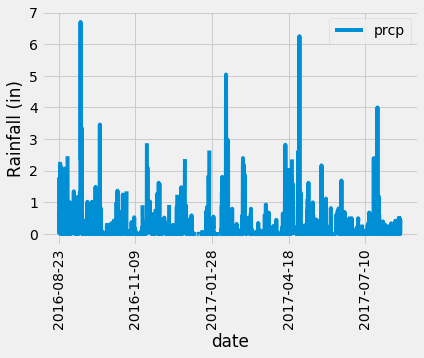

In [213]:
# # Use Pandas Plotting with Matplotlib to plot the data
past_year2.plot(label="Precipitation by Date", rot=90)
plt.ylabel("Rainfall (in)")

In [215]:
# past_year2 = pd.read_sql(session.query(measurement.date, measurement.prcp).filter(func.strftime("%Y-%m-%d", measurement.date) >= '2016-08-23').statement,engine)

In [157]:
# date_index = past_year.set_index('date').sort_index()
# date_index.plot(label="Precipitation by Date", rot=90)

In [217]:
# Use Pandas to calcualte the summary statistics for the precipitation data
past_year2.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [355]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(measurement.station).distinct().count()
station_count

9

In [357]:
# station.__table__.columns.values()

# measurement.__table__.columns.values()

# station_count = session.query(measurement.station, func.count(measurement.station)).\
#                     group_by(measurement.station).\
#                     order_by(func.count(measurement.station)).all()

# station_count

In [361]:
### I was tinkering here to get the station list for the flask app.....
# station.__table__.columns.values()
# measurement.__table__.columns.values()
# station_count = session.query(measurement.station).group_by(measurement.station).all()
# station_count

In [345]:
# What are the most active stations? (i.e. what stations have the most rows)?
station.__table__.columns.values()
measurement.__table__.columns.values()

most_active = session.query(measurement.station, func.count(measurement.station)).\
                    group_by(measurement.station).all()
most_active

[('USC00511918', 1979),
 ('USC00513117', 2709),
 ('USC00514830', 2202),
 ('USC00516128', 2612),
 ('USC00517948', 1372),
 ('USC00518838', 511),
 ('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00519523', 2669)]

In [251]:
# List the stations and the counts in descending order.

decending_count = session.query(measurement.station, func.count(measurement.station)).\
                    group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
decending_count

### I can SEE From this one that USC00519281 has the highest count....

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [252]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
##### Realized after tjos 
#lowest
# lowest = session.query(measurement.station, func.min(measurement.tobs)).\
#                     group_by(measurement.station).all()
# lowest

lowest2 = session.query(measurement.station, func.min(measurement.tobs).label('min')).filter(measurement.station=='USC00519281').all()
lowest2

[('USC00519281', 54.0)]

In [253]:
#highest
# highest = session.query(measurement.station, func.max(measurement.tobs)).\
#                     group_by(measurement.station).all()
# highest

highest2 = session.query(measurement.station, func.max(measurement.tobs).label('max')).filter(measurement.station=='USC00519281').all()
highest2

[('USC00519281', 85.0)]

In [254]:
#average
# average = session.query(measurement.station, func.avg(measurement.tobs)).\
#                     group_by(measurement.station).all()
# average

average2 = session.query(measurement.station, func.avg(measurement.tobs).label('avg')).filter(measurement.station=='USC00519281').all()
average2

[('USC00519281', 71.66378066378067)]

In [267]:
# Choose the station with the highest number of temperature observations.

max_count_obs = session.query(measurement.station, func.count(measurement.station)).\
                    group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()[0]
max_count_obs

('USC00519281', 2772)

In [268]:
## So the result for highest number of temp observations == USC00519397
## !!!!!!!!!!
## After I completed this step, I realized that this IS NOT correct... 
## It's actually USC00519281 .... some something is wrong with my code here...
## Fixed it! I was pulling [-1] from the desc list... needed to pull [0]
## I went back to the previous min/max/avg calcs and filtered out for this station.
## Didn't see that in the prob statement before.


In [269]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
past_year_tobs = session.query(measurement.date, measurement.tobs).filter(measurement.date >= "2016-08-23",measurement.station=='USC00519281').all()

past_year_tobs = pd.DataFrame(past_year_tobs)
past_year_tobs

,date,tobs
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0
...,...,...
347,2017-08-14,77.0
348,2017-08-15,77.0
349,2017-08-16,76.0
350,2017-08-17,76.0


In [270]:
past_year_tobs2 = past_year_tobs.set_index('date')
past_year_tobs2

,tobs
date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
...,...
2017-08-14,77.0
2017-08-15,77.0
2017-08-16,76.0


Text(0.5, 0, 'Temperature')

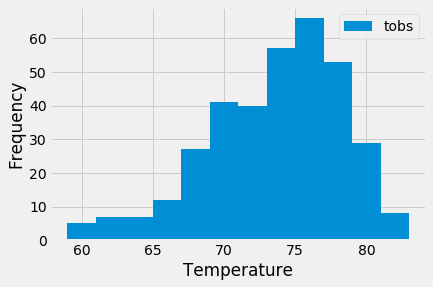

In [272]:
past_year_tobs2.plot.hist(bins=12)
plt.xlabel("Temperature")

## Bonus Challenge Assignment

In [281]:
## TEMP ANALYSIS I
import os
import datetime as dt

In [295]:
path_to_file = os.path.join("Resources", "hawaii_measurements.csv")
temps_df = pd.read_csv(path_to_file)
temps_df.head()

,station,date,prcp,tobs
0,USC00519397,2010-01-01,0.08,65
1,USC00519397,2010-01-02,0.00,63
2,USC00519397,2010-01-03,0.00,74
3,USC00519397,2010-01-04,0.00,76
4,USC00519397,2010-01-06,NaN,73


In [283]:
#Identify the average temperature in June at all stations across all available years in the dataset. Do the same for December temperature.

In [287]:
### This just pulled the actual dates
# date_str = "06"
# session.query(measurement.date).filter(func.strftime("%m", measurement.date) == date_str).all()

In [296]:
# temps_June = temps_df[temps_df['date'].index == 6]['date']
# temps_June

In [366]:
# Going to drop the station column to clean it up since we're looking across all statons:

# temps_df2 = temps_df.drop(columns='station')
# temps_df2

# And I'm also going to cchange the index to the date:
# temps_df3 = temps_df2.set_index('date')
# temps_df3.head()

In [367]:
# temps_df2['date']= pd.to_datetime(temps_df2['date'])
# temps_df2

In [368]:
# temps_df4 = temps_df2.set_index('date').sort_index()
# temps_df4

In [383]:
# so after talking to tutor, it turns out I was correct up there in the first cell... where I said "this just pulled actual dates"
# was so close.....   (yet so far! we all know the saying..)


from scipy import stats

temps_df4_june = session.query(measurement.date, measurement.tobs ).filter(func.strftime('%m', measurement.date) == '06').all()
#temps_df4_june
temps_june = pd.DataFrame(temps_df4_june)
#temps_june
ave_june_temp = temps_june['tobs'].mean()
ave_june_temp

74.94411764705882

In [384]:
temps_df4_dec = session.query(measurement.date, measurement.tobs ).filter(func.strftime('%m', measurement.date) == '12').all()
#temps_df4_dec
temps_dec = pd.DataFrame(temps_df4_dec)
#temps_june
ave_dec_temp = temps_dec['tobs'].mean()
ave_dec_temp

71.04152933421226

In [394]:
## The independent t-test is also called the two sample t-test, student’s t-test, or unpaired t-test. 
## It’s an univariate test that tests for a significant difference between the mean of two unrelated groups.

## Since the weather in Hawaii in June and the weather in Hawaii in Dec are unrelated, this test should work to compare the datasets! 

# scipy.stats.ttest_ind(two_data.loc['cat'], two_data.loc['cat2'], equal_var=False) <-- example

# What we're testing for here is Null hypothesis (H0): u1 = u2, which translates to:
# ==the mean of sample 1 is equal to the mean of sample 2

hawaii_ttest = stats.ttest_ind(temps_june['tobs'], temps_dec['tobs'])
hawaii_ttest

Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)

In [395]:
## The test results show pvalue_hawaii_ttest <<<< p_value_95%confidence, therefore the null value is rejected.
## The difference in temps means is significant.

## HOWEVER, manual inspection of the data concludes a last dataset year of 2017 with incomplete months (08-23-2017 end date) -- 
## A missing December 2017 skews this data and more analysis is required, but also outside the scope of this homework problem.
## For sake of time (and points), moving on...

In [411]:
## TEMP ANALYSIS II


# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2015-07-01', '2016-07-25'))

[(56.0, 74.62625451625853, 86.0)]


NameError: name 'start_date' is not defined

In [402]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.



prior_year_start = start_date - dt.timedelta(days=365)

prior_year_end = end_date - dt.timedelta(days=365)

NameError: name 'start_date' is not defined

In [ ]:
def calc_temps_prior_year(prior_year_start, prior_year_end):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= prior_year_start).filter(measurement.date <= prior_year_end).all()

# function usage example
print(calc_temps_prior_year(prior_year_start, prior_year_end))

## This is working but I've got to be able to put in 

In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


### This is sample code from matplotlib hw "par_standard_error"
# plt.figure(figsize=(10,5))
# plt.errorbar(np.arange(len(samples))+1, means, sems, fmt="o", color="b",
#             alpha=0.5, label="Mean of House Prices")
# plt.xlim(0, len(means)+1)
# plt.xlabel("Sample Number")
# plt.ylabel("Mean of Median House Prices ($1000)")
# plt.legend(loc="best", fontsize="small", fancybox=True)
# plt.show()




In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [406]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
